## 1. Подготовка данных

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import numpy as np
import re
import requests
import json

### Загрузка и просмотр данных

In [54]:
data = pd.read_csv('rest_data.csv') 

In [55]:
data.sample(5)

,id,object_name,chain,object_type,address,number
6160,70125,Шоколадница,да,кафе,"город Москва, Профсоюзная улица, дом 129А",55
9815,170232,Little Garden Kitchen&Bar,нет,ресторан,"город Москва, Большой Кисельный переулок, дом ...",70
8127,149237,Sio столовая,нет,столовая,"город Москва, Летниковская улица, дом 10, стро...",86
7308,130363,Кофе Моментс,нет,кафе,"город Москва, улица Ленинская Слобода, дом 26,...",2
5292,152980,Гранд Круассан,нет,кафетерий,"город Москва, Новодмитровская улица, дом 1, ст...",25


In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


Пропусков нет, тип данных правильный. Проверим данные о количестве посадочных мест на выбросы. Выведем характиристику множества и построим боксплот.

In [57]:
data['number'].describe(percentiles = [0.25, 0.5, 0.75, 0.95])

count    15366.000000
mean        59.547182
std         74.736833
min          0.000000
25%         12.000000
50%         40.000000
75%         80.000000
95%        214.000000
max       1700.000000
Name: number, dtype: float64

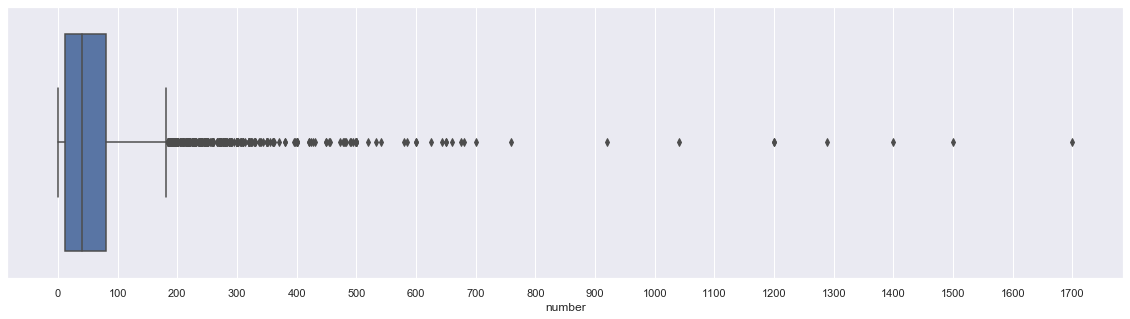

In [58]:
sns.set(rc={'figure.figsize':(20,5)})
ax = sns.boxplot(x=data["number"])
ax.xaxis.set_major_locator(ticker.MultipleLocator(100))

Есть большие выбросы. Удалим 5% выбросов. Это все значения больше 214.

In [59]:
data = data[data['number'] < 214]

Заменим некоторые длинные значения в столбце **object_type** на более короткие, для удобства построения графиков.

In [60]:
data = data.replace('предприятие быстрого обслуживания', 'фаст-фуд')
data = data.replace('магазин (отдел кулинарии)', 'кулинария')

**ВЫВОД:** Данные готовы для анализа.

## 2. Анализ данных

### 2.1 Соотношение видов объектов общественного питания по количеству.

Подсчитаем количество уникальных значений в столбце **object_type**. Построим график.

In [61]:
object_group = data['object_type'].value_counts().reset_index() # - количество уникальных значений 

In [62]:
sns.set(context='notebook',      
        style='whitegrid',  
        palette= 'pastel',  
        font='sans-serif',
        rc={'figure.figsize':(15,10)})

Text(0.5, 0, 'количество')

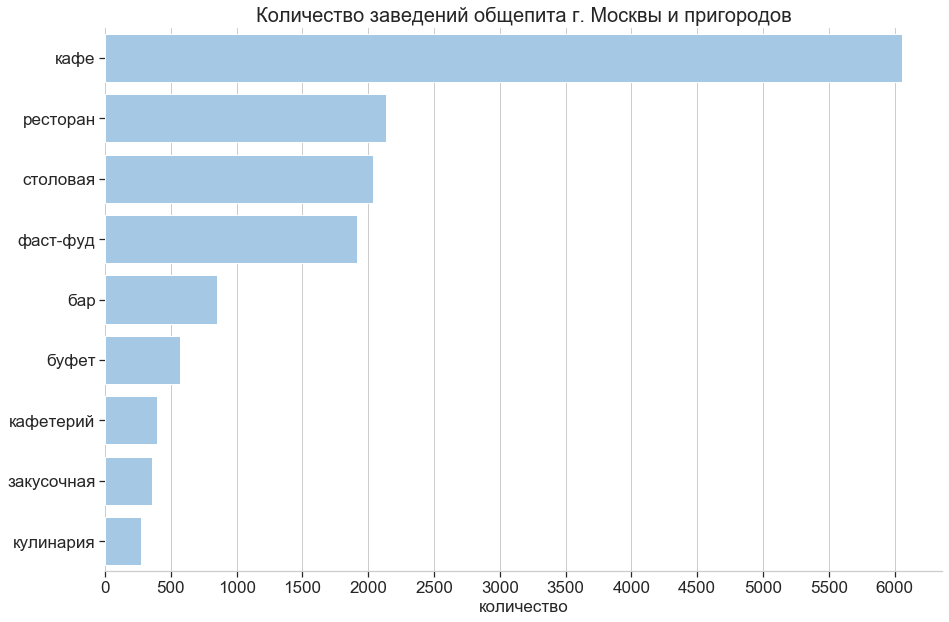

In [63]:
ax = sns.barplot(x = 'object_type', y= 'index', ci=False, orient = 'h', data =object_group, color = '#9ACAEF')
     
sns.despine(left=True)

ax.tick_params(axis = 'both',    #  Применяем параметры к обеим осям
               which = 'major',    #  Применяем параметры к основным делениям
               labelsize = 17,    #  Размер подписи
               bottom = True,    #  Рисуем метки снизу    
               left = True,    #  слева
               labelbottom = True,    #  Рисуем подписи снизу
               labelleft = True,    #  слева
               )

ax.xaxis.set_major_locator(ticker.MultipleLocator(500))
ax.set_title('Количество заведений общепита г. Москвы и пригородов', fontsize = 20)
ax.set_ylabel('')
ax.set_xlabel('количество', fontsize = 17)

**ВЫВОД** Самый распространенный вид общепита - кафе.
Если исходить из того что количество заведений одного типа является метрикой его популярности и востребованности то, тут кафе (чуть более 6000 заведений) на первом месте с трекратным отрывом. Далее по убыванию, - ресторан, столовая и фаст-фуд (примерно по 2000).

### 2.2 Соотношение сетевых и несетевых заведений по количеству.


Сгруппируем данные по типам обьектов питания. Найдем их количество среди сетевых и не сетевых обьектов.

In [64]:
# - сводная таблица по типам обьектов. сумма обьектов сетевых / несетевых
yes_no_chain = data.pivot_table(index = 'object_type', columns = 'chain', values = 'id', aggfunc = 'count')

# - замена названий столбцов
yes_no_chain.columns = ['chain', 'not_chain'] 

# - расчет суммарного количества объектов
yes_no_chain['total'] = yes_no_chain['chain']  + yes_no_chain['not_chain']

# - процент сетевых объектов
yes_no_chain['prosent_chain'] = yes_no_chain['chain'] / (yes_no_chain['chain'] + yes_no_chain['not_chain'] )

# - сортировка для графика
yes_no_chain = yes_no_chain.sort_values(by = 'total', ascending=False)
yes_no_chain = yes_no_chain.reset_index()
yes_no_chain

,object_type,chain,not_chain,total,prosent_chain
0,кафе,1379,4679,6058,0.227633
1,ресторан,507,1630,2137,0.237248
2,столовая,3,2036,2039,0.001471
3,фаст-фуд,782,1132,1914,0.408568
4,бар,37,812,849,0.043581
5,буфет,11,557,568,0.019366
6,кафетерий,52,346,398,0.130653
7,закусочная,56,303,359,0.155989
8,кулинария,78,195,273,0.285714


Построим график который отображает количество сетевых и не сетевых объектов общепита по разным типам.

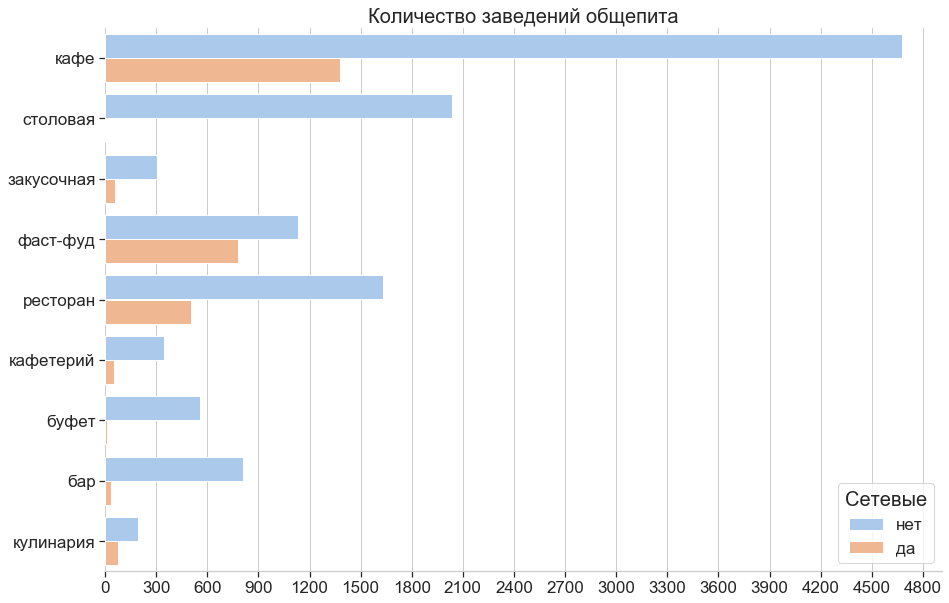

In [65]:
ax = sns.countplot(y='object_type', hue='chain', data=data,  orient='h') 

sns.despine(left=True)

ax.set_title('Количество заведений общепита', fontsize = 20)
ax.set_ylabel('')
ax.set_xlabel('')

ax.tick_params(axis = 'both',    
               which = 'major',    
               labelsize = 17,    
               bottom = True,    
               left = True,
               labelbottom = True,    
               labelleft = True,    
               )

ax.xaxis.set_major_locator(ticker.MultipleLocator(300))

ax.legend(fontsize = 17,
          title = 'Сетевые',    
          title_fontsize = '20'    
         )

Для наглядности построим другой график где будет отображен процент сетевых обьектов от общего количества.

Text(178, 8.1, '28.6%')

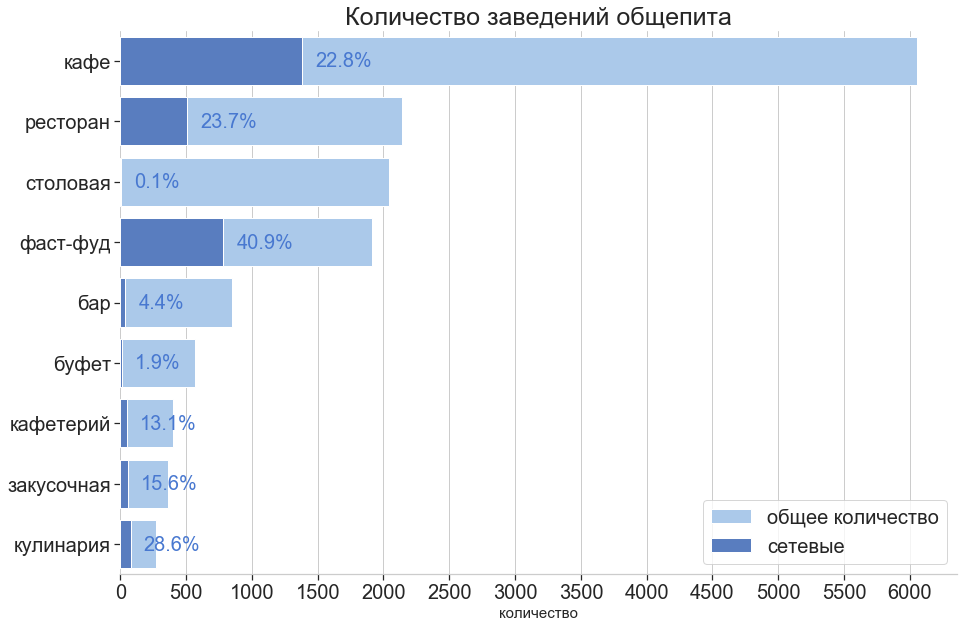

In [66]:
sns.set_color_codes("pastel")
ax = sns.barplot(x = 'total', y='object_type', data=yes_no_chain, label="общее количество", color="b")

sns.set_color_codes("muted")

ax = sns.barplot(x = 'chain', y='object_type', data=yes_no_chain, label="сетевые", color="b") 
    
sns.despine(left=True)

ax.set_title('Количество заведений общепита', fontsize = 25)
ax.set_ylabel('')
ax.set_xlabel('')

ax.tick_params(axis = 'both',    
               which = 'major',    
               labelsize = 20,    
               bottom = True,    
               left = True,
               labelbottom = True,  
               labelleft = True,  
               )

ax.xaxis.set_major_locator(ticker.MultipleLocator(500))
ax.set_xlabel('количество', fontsize = 15)

ax.legend(fontsize = 20,
         ) 

ax.text(yes_no_chain.loc[0, 'chain']+100, 0.1, ('{:0.1%}'.format(yes_no_chain.loc[0, 'prosent_chain'])),
        color = 'b',    #  цвет шрифта
        fontsize = 20)
ax.text(yes_no_chain.loc[1, 'chain']+100, 1.1, ('{:0.1%}'.format(yes_no_chain.loc[1, 'prosent_chain'])),
        color = 'b',    #  цвет шрифта
        fontsize = 20)
ax.text(yes_no_chain.loc[2, 'chain']+100, 2.1, ('{:0.1%}'.format(yes_no_chain.loc[2, 'prosent_chain'])),
        color = 'b',    #  цвет шрифта
        fontsize = 20)
ax.text(yes_no_chain.loc[3, 'chain']+100, 3.1, ('{:0.1%}'.format(yes_no_chain.loc[3, 'prosent_chain'])),
        color = 'b',    #  цвет шрифта
        fontsize = 20)
ax.text(yes_no_chain.loc[4, 'chain']+100, 4.1, ('{:0.1%}'.format(yes_no_chain.loc[4, 'prosent_chain'])),
        color = 'b',    #  цвет шрифта
        fontsize = 20)
ax.text(yes_no_chain.loc[5, 'chain']+100, 5.1, ('{:0.1%}'.format(yes_no_chain.loc[5, 'prosent_chain'])),
        color = 'b',    #  цвет шрифта
        fontsize = 20)
ax.text(yes_no_chain.loc[6, 'chain']+100, 6.1, ('{:0.1%}'.format(yes_no_chain.loc[6, 'prosent_chain'])),
        color = 'b',    #  цвет шрифта
        fontsize = 20)
ax.text(yes_no_chain.loc[7, 'chain']+100, 7.1, ('{:0.1%}'.format(yes_no_chain.loc[7, 'prosent_chain'])),
        color = 'b',    #  цвет шрифта
        fontsize = 20)
ax.text(yes_no_chain.loc[8, 'chain']+100, 8.1, ('{:0.1%}'.format(yes_no_chain.loc[8, 'prosent_chain'])),
        color = 'b',    #  цвет шрифта
        fontsize = 20)

**ВЫВОД.** Еще один показатель - соотношение сетевых и не сетевых заведений по количеству. Если процент сетевых обьектов большой, значит в этом виде объекта, сети чувствуют себя хорошо. Посмотрим на нашу "четверку" прошлых лидеров. "Самое большое кол-во сетей в фаст-фуде(49%), далее кафе и рестораны (23-24%). А вот сетевых столовых нет, видимо там "выживают" одни одиночки.

Несмотря на все это, "одиночных" кафе всеравно больше остальных. На втором месте столовые (более 2000), на третьем рестораны (более 1600), а вот одиночные фастфуды не так популярны.

### 2.3 Анализ количества сетевых заведений и количества посадочных мест.

Отберем объекты где в большом количестве присутствуют сети. Это как ясно выше -  кафе, рестораны, фаст-фуд и кулинария

In [67]:
object_filter = [ 'кафе', 'ресторан', 'фаст-фуд', 'кулинария']

data_chain = data[ data['object_type'].isin(object_filter) ]

chain_yes = data_chain.query(' chain == "да" ')['number']
chain_no = data_chain.query(' chain == "нет" ')['number']

Построим график распределение количества заведений в зависимости от количества посадочных мест

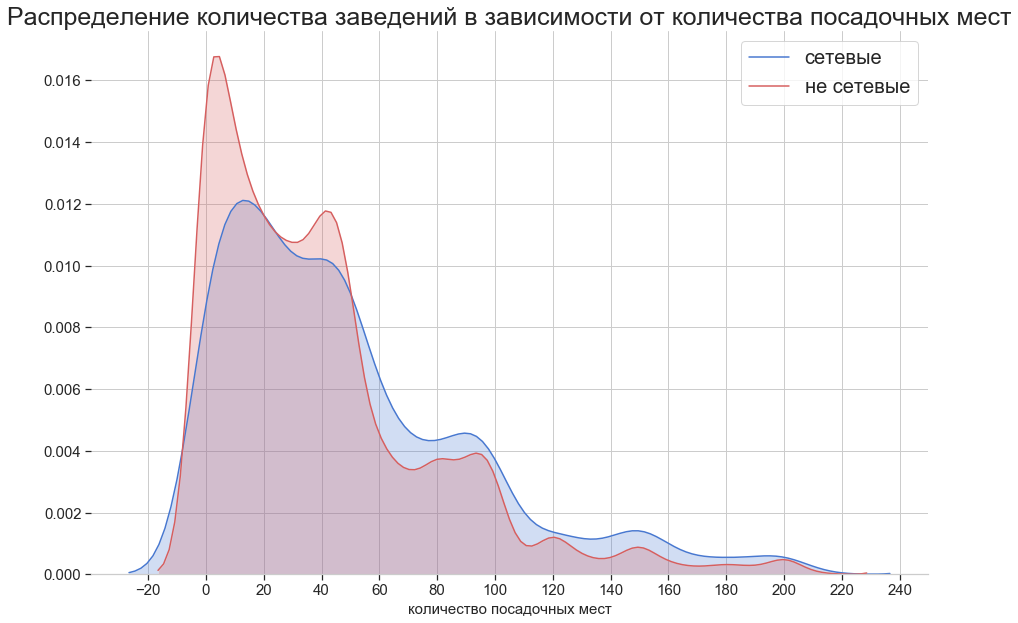

In [68]:
ax = sns.kdeplot(chain_yes, shade=True, color="b", label="сетевые")
ax = sns.kdeplot(chain_no, shade=True, color="r", label="не сетевые")

sns.despine(left=True)

ax.set_title('Распределение количества заведений в зависимости от количества посадочных мест', fontsize = 25)
ax.set_xlabel('количество посадочных мест', fontsize = 15)
ax.set_ylabel('')

ax.tick_params(axis = 'both',    #  Применяем параметры к обеим осям
               which = 'major',    #  Применяем параметры к основным делениям
               labelsize = 15,    #  Размер подписи
               bottom = True,    #  Рисуем метки снизу
               left = True,
               labelbottom = True,    #  Рисуем подписи снизу
               labelleft = True,    #  слева
               )

ax.xaxis.set_major_locator(ticker.MultipleLocator(20))

ax.legend(fontsize = 20,)   

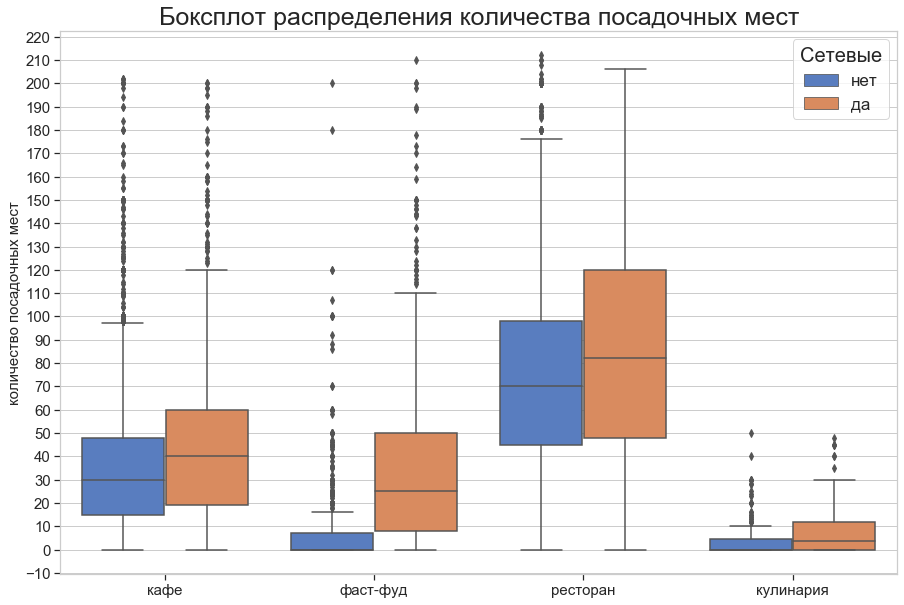

In [69]:
ax = sns.boxplot(x="object_type", y="number", hue="chain",
                    data=data_chain, palette="muted")

ax.tick_params(axis = 'both',    
               which = 'major',    
               labelsize = 15,    
               bottom = True,    
               left = True,
               labelbottom = True,    
               labelleft = True,    
               )

ax.set_title('Боксплот распределения количества посадочных мест', fontsize = 25)
ax.set_xlabel('')
ax.set_ylabel('количество посадочных мест', fontsize = 15)
ax.yaxis.set_major_locator(ticker.MultipleLocator(10)) 


ax.legend(fontsize = 17,
          title = 'Сетевые',    
          title_fontsize = '20'    
         )

**Вывод:** В целом чем больше посадочных мест тем меньше таких заведений, что логично. Как было выявлено ранее, количество сетевых заведений меньше чем не сетевых. Разброс по количеству посадочных мест у сетевых заведений чуть больше, как и среднее количество посадочных мест, особено в фаст-фуде. Это надо учесть после выбора типа объекта общественного питания.


### 2.4 Анализ количества посадочных мест в различных обьектах общепита.

Построим боксплоты - распределения кол-ва посадочных мест,для каждого типа заведения.

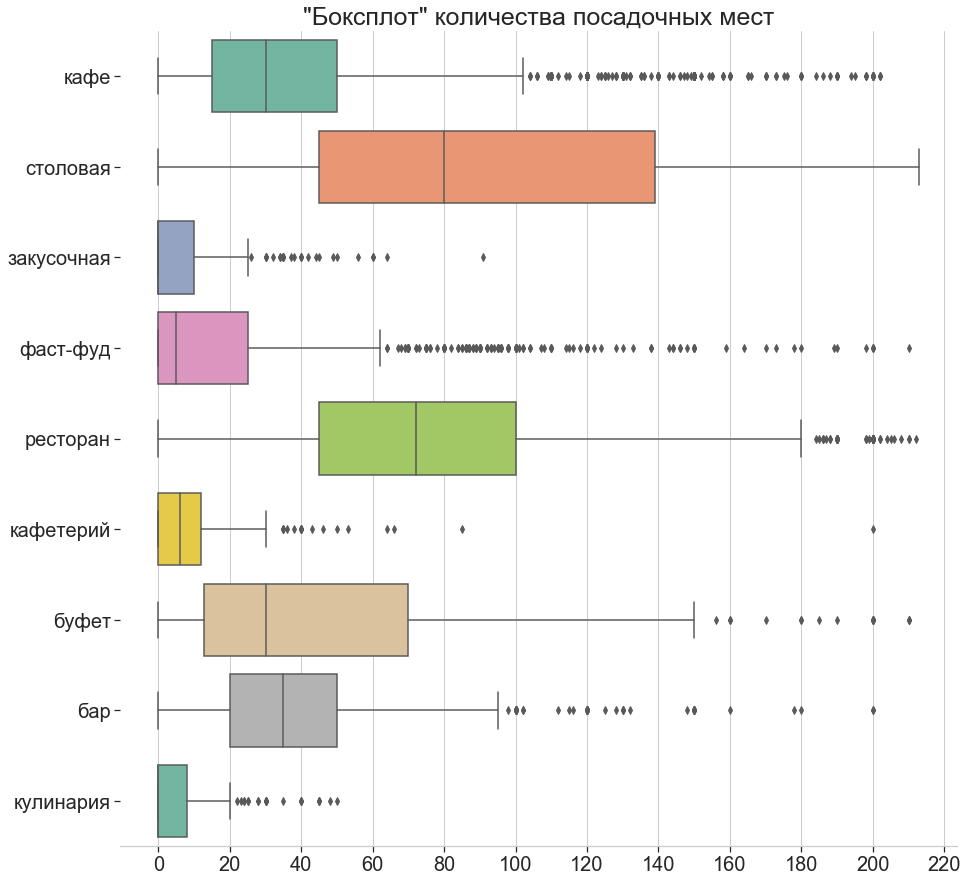

In [70]:
sns.set(context='notebook',
        style='whitegrid',    
        palette= 'muted',   
        font='sans-serif',   
        font_scale=1,
        color_codes=True,
        rc={'figure.figsize':(15,15)})


ax = sns.boxplot(y="object_type", x="number", data = data, orient = 'h', palette="Set2") 
sns.despine(left=True)

ax.set_title('"Боксплот" количества посадочных мест', fontsize = 25)
ax.set_ylabel('')
ax.set_xlabel('')

ax.tick_params(axis = 'both',  
               which = 'major',    
               labelsize = 20,    
               bottom = True,    
               left = True,
               labelbottom = True,    
               labelleft = True,    
               )

ax.xaxis.set_major_locator(ticker.MultipleLocator(20))

Построим диаграммы распределения количества посадочных мест для каждого типа заведения.

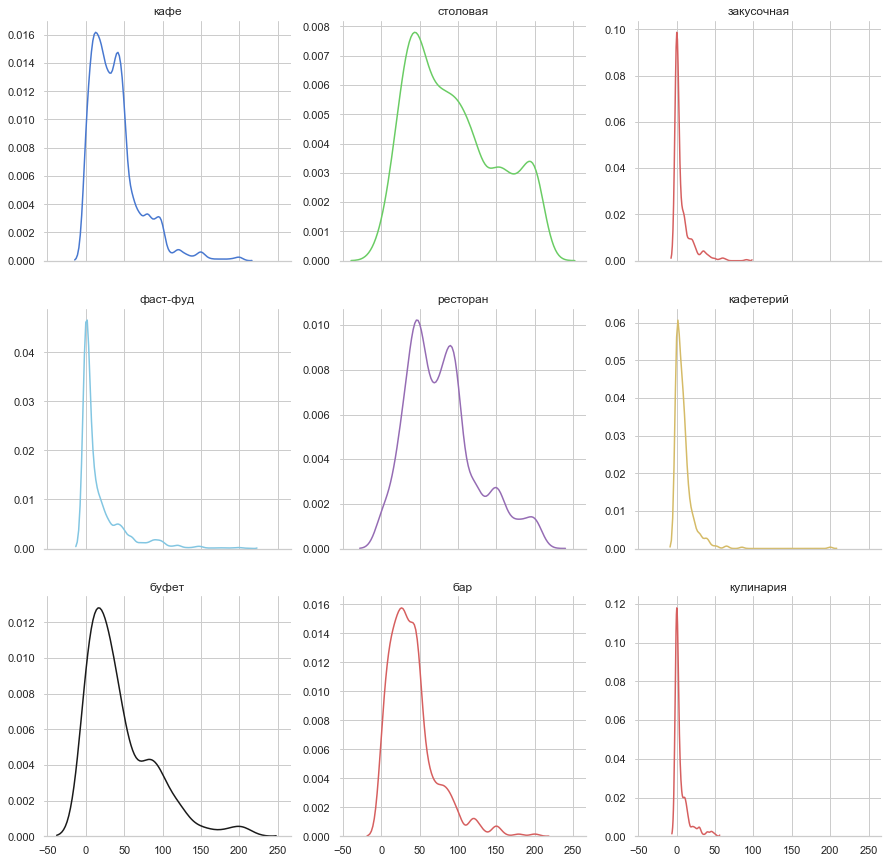

In [71]:
f, axes = plt.subplots(3, 3, figsize=(15, 15), sharex=True)
sns.despine(left=True)

sns.distplot(data.query(' object_type == "кафе" ')['number'], hist=False, color="b", ax=axes[0, 0])
sns.distplot(data.query(' object_type == "столовая" ')['number'], hist=False, color="g", ax=axes[0, 1])
sns.distplot(data.query(' object_type == "закусочная" ')['number'], hist=False, color="r", ax=axes[0, 2])
sns.distplot(data.query(' object_type == "фаст-фуд" ')['number'], hist=False, color="c", ax=axes[1, 0])
sns.distplot(data.query(' object_type == "ресторан" ')['number'], hist=False, color="m", ax=axes[1, 1])
sns.distplot(data.query(' object_type == "кафетерий" ')['number'], hist=False, color="y", ax=axes[1, 2])
sns.distplot(data.query(' object_type == "буфет" ')['number'],hist=False, color="k", ax=axes[2, 0])
sns.distplot(data.query(' object_type == "бар" ')['number'], hist=False, color="r", ax=axes[2, 1])
sns.distplot(data.query(' object_type == "кулинария" ')['number'], hist=False, color="r", ax=axes[2, 2])

axes[0, 0].set(title='кафе', xlabel = '')
axes[0, 1].set(title='столовая', xlabel = '')
axes[0, 2].set(title='закусочная', xlabel = '')
axes[1, 0].set(title='фаст-фуд', xlabel = '')
axes[1, 1].set(title='ресторан', xlabel = '')
axes[1, 2].set(title='кафетерий', xlabel = '')
axes[2, 0].set(title='буфет', xlabel = '')
axes[2, 1].set(title='бар', xlabel = '')
axes[2, 2].set(title='кулинария', xlabel = '')

plt.show()

**ВЫВОД:** По графикам, видно что в среднем самое большое количество посадочных мест в столовых и ресторанах. Столовая также имеет самый большой расброс по количеству мест.

Видно четкое разделение по количеству, закусочные, кафетерий и кулинария имеют минимальное количество мест (до 10) и минимальный разброс. Далее следуют кафе, бары, сетевые фаст-фуды (от 10 до 50) далее рестораны и столовые (от 50). Буфеты начинаются от уровня кафе и дотягивают до некоторых ресторанов и столовых (от 10 до 70)

### 2.5 Сортировка по улицам.


Создадим списки
- с типами пригородов (поселения, другие города, линии, поселки, деревни)
- названиями типов локации (улиц, бульваров, шоссе и пр.)

Создадим три функции:
- первая функция будет сортировать адреса на Москву и пригороды. 
- вторая функция будет находить из адреса - названия улиц, бульваров, шоссе и пр. 
- третья функция будет определять из адреса тип локации - улица, бульвар и пр.


In [72]:
# названия типов локаций
location_names = ['владение','улица','проспект','шоссе','проезд','бульвар','переулок','набережная','площадь','вал','аллея',
                   'квартал','микрорайон','тупик','километр','просек','территория']
# типы пригородов
suburb = ['поселение','город','линия','посёлок','деревня']

In [73]:
def city_or_suburb_check (adress):    # функция сортирует заведения по адресу на Москву и пригороды
    
    separate = re.split(r',', adress)
    if separate[0] != 'город Москва':  # некоторые московские адреса сразу начинаются с названия улиц, линий и пр.
        return 'Москва'
    else:
        for word in separate[1].split(): # название пригорода идет сразу после г.Москва
            if word in suburb:
                return 'пригород'
                break
            elif word in location_names:
                return 'Москва'

In [74]:
def location_name (adress):  # функция возвращает названия улиц, бульваров, шоссе и пр.
        
    separate = re.split(r',', adress)
    if separate[0] != 'город Москва':
        return separate[0].strip()   # strip удаляет пробелы в начале и в конце
    else:
        return separate[1].strip()

In [75]:
def location_type (location_name):   # функция возвращает тип локации - улица, бульвар и пр. из списка location_names
        
    separate = location_name.split()
    
    for word in separate:
            if word in location_names:
                return word
                break

Создадим столбцы с определением адреса (город - пригород), названиями улиц, типом локации.

In [76]:
data['city/suburb'] = data['address'].apply(city_or_suburb_check)
data['location_name'] = data['address'].apply(location_name)
data['location_type'] = data['location_name'].apply(location_type)

In [77]:
data.sample(5)

,id,object_name,chain,object_type,address,number,city/suburb,location_name,location_type
2335,83560,Экстра Виржен,нет,ресторан,"город Москва, улица Покровка, дом 17, строение 1",90,Москва,улица Покровка,улица
15230,205826,KFC,да,ресторан,"город Москва, улица Марьинский Парк, домовладе...",15,Москва,улица Марьинский Парк,улица
8241,21887,Кофемания,да,кафе,"город Москва, Трубная площадь, дом 2",70,Москва,Трубная площадь,площадь
11560,178385,Лепим и варим,нет,кафе,"город Москва, улица Ленинская Слобода, дом 26",10,Москва,улица Ленинская Слобода,улица
7959,22547,Неглинка (при гостинице «Арарат Парк Хаятт»),нет,бар,"город Москва, Неглинная улица, дом 4",33,Москва,Неглинная улица,улица


**ВЫВОД:**  Адреса разделены по названиям и типам локаций, для дальнейшего анализа

### 2.6 Рейтинг улиц Москвы по количеству объектов общественного питания.

Для начала отфильтруем Москву от пригородов.

In [78]:
data_Moscow_street = data[ (data['city/suburb'] == 'Москва')]

Найдем для каждого адреса - район Москвы. Для этого составим функцию и применим к датафрейму.

Ввиду того что код выполняется очень долго. Привожу конечный результат в виде таблицы.

In [79]:
data_Moscow_street = pd.read_csv('data_Moscow_street.csv')

In [80]:
data_Moscow_street.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13785 entries, 0 to 13784
Data columns (total 10 columns):
id               13785 non-null int64
object_name      13785 non-null object
chain            13785 non-null object
object_type      13785 non-null object
address          13785 non-null object
number           13785 non-null int64
city/suburb      13785 non-null object
location_name    13785 non-null object
location_type    13777 non-null object
district         13785 non-null object
dtypes: int64(2), object(8)
memory usage: 1.1+ MB


Удалим "неправильные районы"

In [81]:
error_district = ['квартал № 155','поселок Николаевка','квартал № 65','квартал № 25','Московский',
                  'муниципальный округ Московская Застава','квартал № 12', 'не найден']

data_Moscow_street = data_Moscow_street[ ~data_Moscow_street['district'].isin(error_district) ]

Исключим 'кварталы', 'шоссе', 'микрорайоны', километры', 'владения' т.к. они большие по протяженности и площади.

In [82]:
location_filter = ['проспект','квартал','шоссе','микрорайон','километр', 'владение']
data_Moscow_street_filter = data_Moscow_street[~data_Moscow_street['location_type'].isin(location_filter) ]

Найдем топ 10 улиц по количеству объектов общепита. Построим график.

In [83]:
top10_street = (data_Moscow_street_filter.groupby('location_name', as_index=False)['id'].count()
                .sort_values(by = 'id', ascending = False)
                .reset_index(drop = True)
                .loc[0:10]
               ).copy()
top10_street.columns = ['location_name','count_object_type']

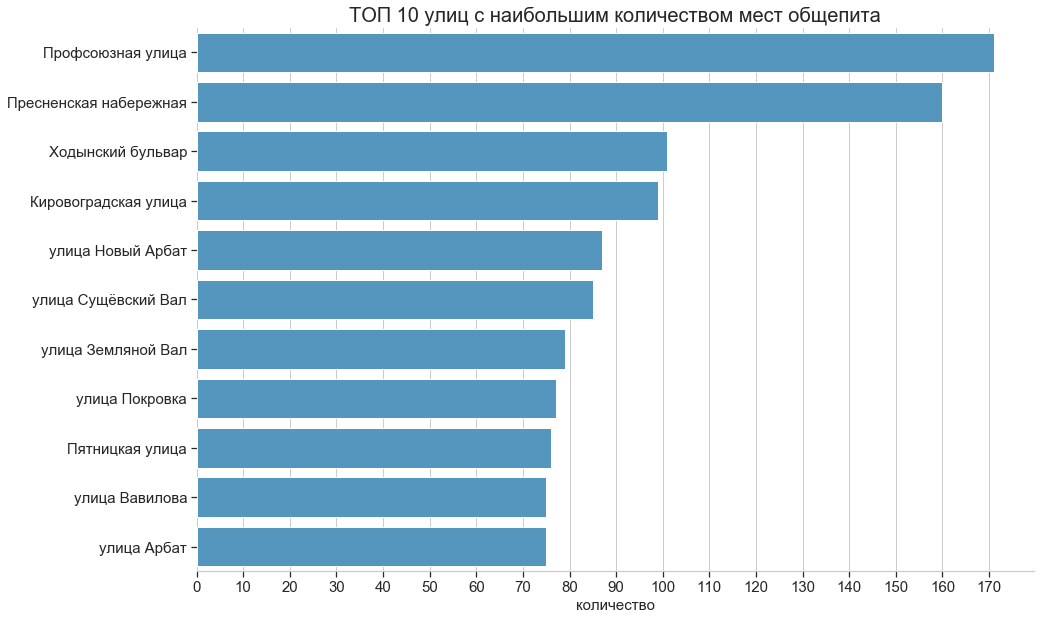

In [84]:
sns.set(context='notebook',      
        style='whitegrid',  
        palette= 'muted',   
        font='sans-serif',   
        font_scale=1,
        color_codes=True,
        rc={'figure.figsize':(15,10)})

ax = (sns.barplot(x='count_object_type',
                  y='location_name',
                  ci=False, orient = 'h', data =top10_street, color = '#439acf')
     )

sns.despine(left=True)

ax.set_title('ТОП 10 улиц с наибольшим количеством мест общепита', fontsize = 20)
ax.set_xlabel('количество', fontsize = 15)
ax.set_ylabel('')

ax.tick_params(axis = 'both',    
               which = 'major',    
               labelsize = 15,   
               bottom = True,    
               left = True,    
               labelbottom = True,    
               labelleft = True,   
               )

ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

Нахождение улицы из ТОП10 в определенном районе - это показатель востребованности объектов общепита в этом районе и в тоже время наличие большой конкуренции в конкретно на данной улице. Найдем районы в которых находятся эти улицы.

In [85]:
top10_street_district = (top10_street.merge(data_Moscow_street, how='left', on = 'location_name')
                     ['district'].unique()
                    )

Теперь найдем улицы с одним объектом общепита.

In [86]:
min_objects_street = (data_Moscow_street_filter.groupby('location_name', as_index=False)['id'].count()
                .sort_values(by = 'id')
                .reset_index(drop = True)
                .query(' id == 1 ')
                     )

Найдем районы в которых находятся эти улицы.

In [87]:
min_objects_street_district = (min_objects_street.merge(data_Moscow_street, how='left', on = 'location_name')
                     ['district'].unique()
                    )

Сопоставим два списка районов, найдем общие.

In [88]:
dictrict_list = []
for district in min_objects_street_district:
    if district in top10_street_district:
        dictrict_list.append(district) 
dictrict_list

['Обручевский район',
 'Таганский район',
 'Пресненский район',
 'Мещанский район',
 'район Марьина Роща',
 'район Ясенево',
 'район Арбат',
 'район Черёмушки',
 'Донской район',
 'Басманный район',
 'район Замоскворечье',
 'Тверской район',
 'район Коньково',
 'район Тёплый Стан',
 'Хорошёвский район',
 'Гагаринский район',
 'район Чертаново Северное']

**ВЫВОД:** Проанализировали районы Москвы на востребованность к объектам общепита. Из этих районов отобрали те где имеются улицы с минимальным кол-вом объектов общепита. Эти районы можно рекомендовать для кафе.

### 2.7 Анализ районов Москвы

Еще один вариант, найти оптимальные районы для кафе, это посчитать плотность населения района и соотнести его с численностью имеющихся заведений.

Загрузим  данные по численности населения по районам Москвы. CSV файл сформирован из данных по ссылке [тут](https://ru.wikipedia.org/wiki/%D0%A1%D0%BF%D0%B8%D1%81%D0%BE%D0%BA_%D1%80%D0%B0%D0%B9%D0%BE%D0%BD%D0%BE%D0%B2_%D0%B8_%D0%BF%D0%BE%D1%81%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B9_%D0%9C%D0%BE%D1%81%D0%BA%D0%B2%D1%8B)

In [89]:
moskow_populiation = pd.read_csv('moskow_populiation.csv', sep=';')

In [90]:
moskow_populiation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 3 columns):
district       125 non-null object
S_km           125 non-null float64
populiation    125 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 3.1+ KB


Составим рейтинг районов по коэфициенту -  "плотность населения"/ "количество_объектов общепита". Для этого
 - расчитаем в таблице **moskow_populiation**, плотность населения
 - сгруппируем таблицу **data_Moscow_street** по районам, предварительно удалив слово "район" с помощью функции
 - объеденим две таблицы и расчитаем соотношение плотности населения к количеству уже имеющихся объектов.

In [91]:
moskow_populiation['density'] = moskow_populiation['populiation'] / moskow_populiation['S_km']

In [92]:
def delete (district):  # функция возвращает названия улиц, бульваров, шоссе и пр.
     
        remove = ['район']
        for word in remove:
            district = district.replace(word, "")
            return district.strip()

In [93]:
data_Moscow_street['district'] = data_Moscow_street['district'].apply(delete)

In [94]:
data_Moscow_street_group = data_Moscow_street.groupby('district')['id'].count().reset_index()
data_Moscow_street_group.columns = ['district', 'count_objects']

In [95]:
district_pop = data_Moscow_street_group.merge(moskow_populiation, how='left', on = 'district')

In [96]:
district_pop['density/count'] = district_pop['density'] / district_pop['count_objects']

Выведем самые ТОП 10 районов по коэфициенту.

In [97]:
district_pop_top10 = district_pop.sort_values(by = 'density/count', ascending = False).reset_index()
district_pop_top10.head(10)

,index,district,count_objects,S_km,populiation,density,density/count
0,36,Капотня,1,8.06,32399.0,4019.727047,4019.727047
1,20,Восточный,2,3.14,13689.0,4359.554140,2179.777070
2,68,Новокосино,24,3.60,107907.0,29974.166667,1248.923611
3,8,Бескудниковский,35,3.30,79603.0,24122.121212,689.203463
4,18,Восточное Дегунино,40,3.77,98923.0,26239.522546,655.988064
5,2,Алтуфьевский,28,3.25,57596.0,17721.846154,632.923077
6,116,Южное Медведково,37,3.88,85698.0,22087.113402,596.949011
7,19,Восточное Измайлово,35,3.85,78154.0,20299.740260,579.992579
8,98,Текстильщики,38,5.92,105267.0,17781.587838,467.936522
9,64,Некрасовка,28,5.58,71943.0,12893.010753,460.464670


In [98]:
district_pop_top10_list = district_pop_top10 ['district'].loc[0:10]
district_pop_top10_list

0                 Капотня
1               Восточный
2              Новокосино
3         Бескудниковский
4      Восточное Дегунино
5            Алтуфьевский
6        Южное Медведково
7     Восточное Измайлово
8            Текстильщики
9              Некрасовка
10    Северное Медведково
Name: district, dtype: object

**ВЫВОД:** Меньше всего объектов общепита на единицу плотности населения в районах Капотня, Восточный, Новосокино. Эти районы можно рекомендовать для кафе.

### 2.8 Районы сетевых заведений.

Еще один вариант поиска оптимального района это районы нахождения сетевых заведений. Крупные сети имеют ресурсы и своих аналитиков чтобы более тщательно анализировать и выбирать места. Их заведения не будет находиться там где не выгодно.

Отберем ТОП5 сетевых заведений по количеству и найдем районы с самым большим количеством этих сетевых заведений.

In [99]:
TOP5_chain = (data_Moscow_street.query(' chain == "да" ')
                    .groupby('object_name',  as_index=False)['id'].count()
                    .sort_values(by = 'id', ascending = False)
                    .reset_index(drop = True)
                    .loc[0:5]
                    )
TOP5_chain

,object_name,id
0,KFC,138
1,Шоколадница,137
2,Бургер Кинг,112
3,Макдоналдс,106
4,Домино'с Пицца,86
5,Теремок,76


In [100]:
chain_district = (data_Moscow_street[ data_Moscow_street['object_name'].isin(TOP5_chain['object_name'].unique()) ]
       .groupby('district',  as_index=False)['id'].count()
       .sort_values(by = 'id', ascending = False)
       .reset_index())
chain_district.head()

,index,district,id
0,6,Басманный,27
1,87,Тверской,19
2,37,Красносельский,18
3,108,Ясенево,17
4,48,Марьино,17


Отберем районы где сетевых заведений больше 10 на район.

In [101]:
top_chain_district = chain_district.query('id > 10 ')['district']
top_chain_district

0                 Басманный
1                  Тверской
2            Красносельский
3                   Ясенево
4                   Марьино
5               Пресненский
6            Соколиная Гора
7               Даниловский
8                 Мещанский
9               Хорошёвский
10                 Аэропорт
11                Хамовники
12             Левобережный
13    Чертаново Центральное
14                Измайлово
15            Замоскворечье
16              Обручевский
17             Марьина Роща
Name: district, dtype: object

**ВЫВОД**. Отобранные районы, еще один вариант места для кафе.

Итого, составим список  всех районов рекомендованных для будущего кафе

'Алтуфьевский',
 'Арбат',
 'Аэропорт',
 'Басманный',
 'Бескудниковский',
 'Восточное Дегунино',
 'Восточное Измайлово',
 'Восточный',
 'Гагаринский',
 'Даниловский',
 'Донской',
 'Замоскворечье',
 'Измайлово',
 'Капотня',
 'Коньково',
 'Красносельский',
 'Левобережный',
 'Марьина Роща',
 'Марьино',
 'Мещанский',
 'Некрасовка',
 'Новокосино',
 'Обручевский',
 'Пресненский',
 'Северное Медведково',
 'Соколиная Гора',
 'Таганский',
 'Тверской',
 'Текстильщики',
 'Тёплый Стан',
 'Хамовники',
 'Хорошёвский',
 'Чертаново Северное',
 'Чертаново Центральное',
 'Черёмушки',
 'Южное Медведково',
 'Ясенево'

### 2.8 Распределение количества посадочных мест для улиц с большим количеством объектов общественного питания.

Разделим все улицы на две группы, с большим кол-вом обьектов общепита и с маленьким количеством. За границу возьмем 10 обьектов общепита. 

In [102]:
delimiter = 80

street_group = data_Moscow_street_filter.groupby('location_name', as_index=False )['id'].count()

street_match_objects = street_group[ street_group['id'] > delimiter ]
street_few_objects = street_group[ street_group['id'] <= delimiter ]

data_street_match_objects = street_match_objects.merge(data[['location_name','number']], how = 'left', on = 'location_name')
data_street_few_objects = street_few_objects.merge(data[['location_name','number']], how = 'left', on = 'location_name')

Построим распределения посадочных мест.

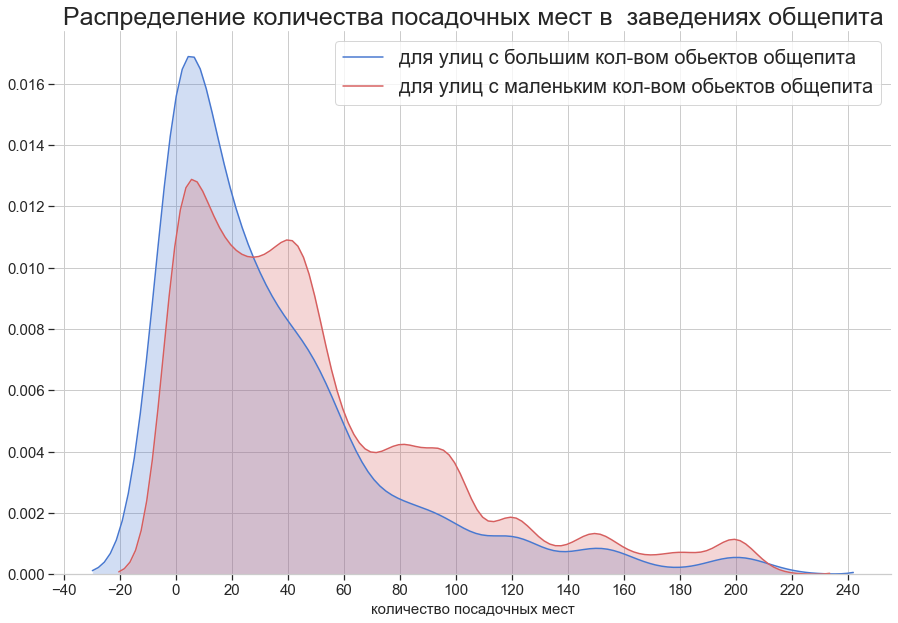

In [103]:
ax = sns.kdeplot(data_street_match_objects['number'], shade=True, color="b",
                 label="для улиц с большим кол-вом обьектов общепита")
ax = sns.kdeplot(data_street_few_objects['number'], shade=True, color="r",
                 label="для улиц с маленьким кол-вом обьектов общепита")

sns.despine(left=True)

ax.set_title('Распределение количества посадочных мест в  заведениях общепита', fontsize = 25)
ax.set_xlabel('количество посадочных мест', fontsize = 15)
ax.set_ylabel('')

ax.tick_params(axis = 'both',    
               which = 'major',    
               labelsize = 15,    
               bottom = True,    
               left = True,
               labelbottom = True,    
               labelleft = True,   
               )

ax.xaxis.set_major_locator(ticker.MultipleLocator(20))

ax.legend(fontsize = 20)   

Построим боксплоты распределения кол-ва посадочных мест, для двух групп.

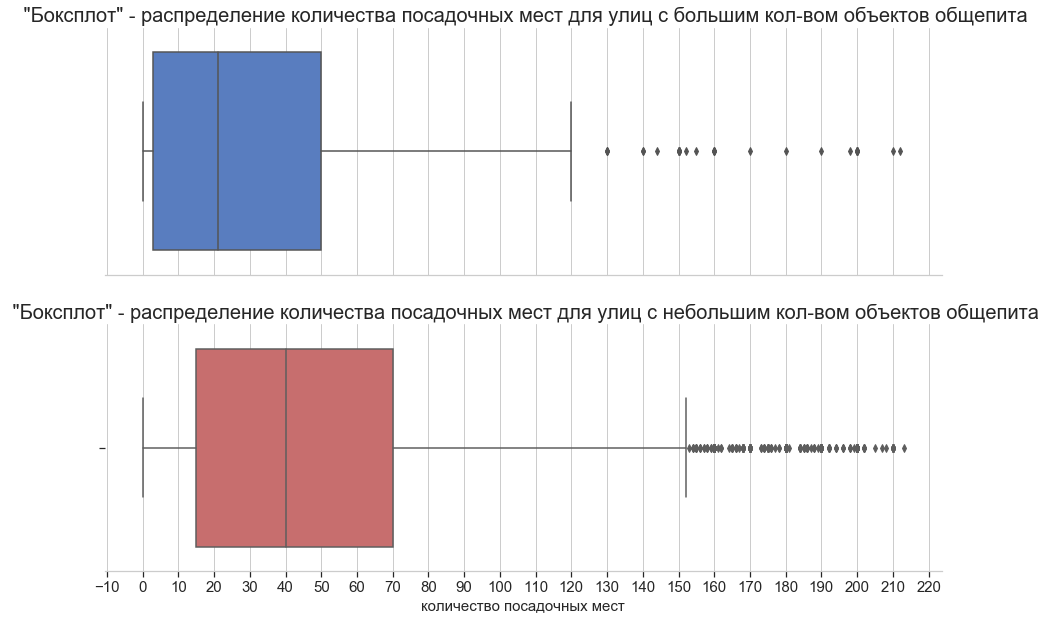

In [104]:
f, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

sns.despine(left=True)

ax_1 = sns.boxplot(data_street_match_objects['number'], color="b", ax=axes[0])
ax_2 = sns.boxplot(data_street_few_objects['number'], color="r",  ax=axes[1])



ax_1.set_title(' "Боксплот" - распределение количества посадочных мест для улиц с большим кол-вом объектов общепита',
               fontsize = 20)
ax_2.set_title(' "Боксплот" - распределение количества посадочных мест для улиц с небольшим кол-вом объектов общепита'
               , fontsize = 20)
ax_1.set_xlabel('')
ax_2.set_xlabel('количество посадочных мест', fontsize = 15)


ax_2.tick_params(axis = 'both',    #  Применяем параметры к обеим осям
               which = 'major',    #  Применяем параметры к основным делениям
               labelsize = 15,    #  Размер подписи
               bottom = True,    #  Рисуем метки снизу
               left = True,
               labelbottom = True,    #  Рисуем подписи снизу
               labelleft = True,    #  слева
               )

ax_2.xaxis.set_major_locator(ticker.MultipleLocator(10)) 

**ВЫВОД:** В среднем количество посадочных мест на улицах с большим кол-вом объектов общепита, чуть меньше чем на других улицах (на 20%). Т.е. при выборе улицы с большой плотностью объектов, следует уменьшать кол-во посадочных мест.

## 3. Общий вывод и рекомендации о виде заведения, количестве посадочных мест, районе расположения. 

Проанализируем рассмотренные показатели:

#### 1. Количество заведений.

С одной стороны количество типов заведений является метрикой популярности и востребованности с другой стороны, чем выше количество тем выше конкуренция. По количеству кафе (чуть более 6000 заведений) на первом месте. Далее идут - ресторан, столовая и фаст-фуд (примерно по 2000). Остальных еще меньше. 


#### 2. Количество посадочных мест.

В среднем рестораны а особенно столовые имеют большое кол-во посадочных мест.(70 и 80  соответственно). Среднее кол-во мест имеют кафе, буфет, бар, и сетевой фаст-фуд, или небольшой ресторан.(30-40 мест). В остальных объектах кол-во мест в пределах 10.


#### 3. Процент сетевых заведений

Самое большое кол-во сетей в фаст-фуде(49%), далее идут кафе и рестораны (23-24%). А вот например сетевых столовых нет. С одной стороны сети это конкуренты "одиночным" объектам общепита. И в то же время это показатель того что сети чувствуют себя "хорошо",в этих типах общепита. Это нужно учитывать на перспективу, прижелании расширяться из одиночного объекта в сеть. По этому показателю оптимальнее всего выглядит кафе т.к. хватает и "одиночных" и "сетевых" кафе. Да и "одиночных" кафе всеравно больше остальных - ресторанов и столовых (более 4500). Фаст-фуд хоть и первый по этому показателю, но там можно сказать все занимают сети. Одиночные фасфуды хоть и составляют 50% от общего их количества, однако они сильно отличаются от "сетевых т.к "среднее кол-во мест там минимально (менее 10). Так что при выборе фаст-фуда на началльном этапе придется конкурировать с уже известными сетями.
 

#### 4. Итого:

Оптимальным для выбора видятся вид общепита - кафе, т.к. они очень популярны, имеют не большое кол-во посадочных мест, и в этом виде общепита хорошо себя чувствуют как сетевые так и несетевые заведения. Небольшой ресторан тоже вариант, но они менее популярны, и среднее кол-во посадочных мест там больше. Буфет и бар тоже в среднем имеют небольшое кол-во мест, но еще менее популярны чем рестораны. Столовые - слишком большие, а сетевых столовых нет - что показательно. Фаст-фуды это только сетевые обьекты, т.к. несетевые фасфтуды это категория закусочных, кафетерия или кулинарии по количеству мест (до 10). 